# Cardiomyocite cells cultures behavior investigation


## Data Analysis and Comparisons

### Optical data visualization

In this first code segment, the aim will be to split the video bits, in order to highlight electrodes, along with the cells within each electrode.

This will be done by:

- Using a highpass filter to split the image based on the darker color of transistor wiring.
- Matrix of electrodes will be determined based on the transistor wires crossings, that split almost right through the middle of an electrode
  (the shift to an electrode will be estimated as a visual estimate in pixels)
- 


In [7]:
###INCLUDES
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [8]:
###PATHS
media_path = '../../data/'
##FILE TO WORK ON FOR NOW 
file2 = media_path + 'TESTVIDEOS/.10.1.avi'
file1 = media_path + 'TESTVIDEOS/Nifedipine4_CentreG18_basS9_video.AVI'
stream_url = "http:169.254.235.60:8080"
file = stream_url

#### Original Stream 

In [9]:
cap = cv2.VideoCapture(file)
width  = cap.get(3)   # float `width`
height = cap.get(4)  # float `height`

##Assert
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

##window creation
# Set the display window size
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size 40% smaller

##READ FRAME BY FRAME
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    #Display Frame
    cv2.imshow('Frame',frame)
    #Exit on Q
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  #If no frame left close
  else: 
    break
 
cap.release()
cv2.destroyAllWindows()

### Transistor Wiring contours

In [85]:
#####CLEANING CONTOURS
###This function filters noise based on 
def cleanContours(contours):
    new_contours = []
    for contour in contours:
        if (len(contour) > 60):
            new_contours.append(contour)
    return new_contours

In [11]:
###HIGHPASS FILTER FOR TRANSISTORS CONTOURING
    ##DISPLAY OF CONTOURS

cap = cv2.VideoCapture(file)
width  = cap.get(3)   # float `width`
height = cap.get(4)  # float `height`

##Assert
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

##window creation
# Set the display window size
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size - 40% smaller

##READ FRAME BY FRAME
while True:
    ret, frame = cap.read()
    if ret ==True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 90, 155, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

        ###COPY FRAME 
        frame_trans_contour = frame.copy()
        #####clean contours and contour rectangle shapes
        clean_wires_contours = cleanContours(contours_wires)

        for contour in clean_wires_contours:
                area = cv2.contourArea(contour)
                if area > 1000:
                    x,y,w,h = cv2.boundingRect(contour)
                    cv2.rectangle(frame_trans_contour, (x, y), (x + w, y + h), (0, 255, 0), 3)   
                            ###drawing raw contours instead
                    #cv2.drawContours(image=frame_trans_contour, contours=clean_wires_contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    #Display Frame
        cv2.imshow('Frame',frame_trans_contour)
    #Exit on Q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



### Electrodes contours
- This version splits the contours of electrodes, based on the side size of a transistor, thus it matches any zoom setting.
- Said "size" of the transistor is obtained in pixel size though vizualisation. For now, an electrode side size is thought to be the exact same.
(100micrometers).
- Each electrode considers a "contour" of their own, which can be seen on the image and in real size, is equal to 5micrometers. 
- Each electrode will be attributed the top and left 'contours' that surround it.
- The shift from A transistor contour, to an electrode's, will be done by shifting bottom, and right.
Below, in the $shift(x , y, tft\_size)$ function the shift is done on $x$, $y$, pixels with the size of the side of the electrode being equal to $tft\_size$ 

In [12]:
### Side of electrode in pixels on the microscope referrence ()
X = Y = 216.5 ###correspond à 100 micromètres
x_elec_side = 121.5 
y_elec_side = 100
##NO scaling to screen tft pixel side size for X_shift, Y_shift. Check below function for scaling
X_shift = X - x_elec_side
Y_shift = Y - y_elec_side
def shift(x, y, tft_size):
    X_shift_scaled = (X_shift*tft_size) / X 
    Y_shift_scaled = (Y_shift*tft_size) / Y
    #print ("SHIFT SCALED : " , X_shift_scaled, Y_shift_scaled, tft_size)
    return round(x + X_shift_scaled), round(y + Y_shift_scaled)

##### Displaying and detecting contour of each electrode
Some variables should be adjusted for better precision : 
- $delay$ : 
- $frame\_nb\_tft\_size$ 
- $thresh\_px$

##### Splitting data from each rectangle into a matrix
Considering the "live" and frame by frame nature of the code, if a electrode is mis-detected or not detected in a single frame, the algorithm will consider the previous detection of it. 
If it is it's first detection, it will be added (see $clean\_rectangle(...)$)
If a rectangle disappears for over 3 frames, then it will be deleted from the general array.

##### Issues to consider
In this first implementation, the squares are disorganized, put into the $bounding\_rectangles$ array. Accessing them might be costly.


In [58]:
###Determines whether a square was already detected :
####If it was, and the new rectangle is smaller in size, it is replaced.
#####If the rectangle is not square shaped, it is also not kept
def clean_rectangle(new_rect, bounding_rectangles, thresh):
    for rect in bounding_rectangles :
        if (abs(new_rect[0] - rect[0]) <= thresh) and (abs(new_rect[1] - rect[1]) <= thresh):
            #########This below case is the case where it is a same or way bigger square. If it is, then we ignore
            if (new_rect[2] >= rect[2] + thresh ) :
                return rect[0], rect[1], rect[2], rect[3]
        else:
            x, y, w, h = new_rect[0], new_rect[1], new_rect[2], new_rect[3]
            bounding_rectangles.append([x, y, w, h])
            return x,y,w,h



In [87]:
###SPECIFIES THE DELAY AT WHICH CONTOUR DETECTION SHOULD BE STARTED
delay = 2 ##in seconds
frame_nb_tft_size = 50 ###number of frames to check for the most common side size
thresh_px = 15 ##general threshhold in pixel for estimates -> should be calculated depending the amount of squares 
##frame count
frame_cnt = 0
tft_size = 0 ##in pixels
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size - 40% smallerq

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 170, 220, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            x, y = shift(x, y, tft_size)
                            cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                            #print("TFT SIZE = ", tft_size, tft_sizes)

            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)        
            tft_sizes = []
            bounding_rectangles = [[-100, -111, -222, -333]] ###re-initialization of bounding rectangles 


    #Display Frame
        cv2.imshow('Frame',frame_trans_contour)
    #Print on R
    if cv2.waitKey(1) & 0xFF == ord('r'):
        print(bounding_rectangles, tft_size)
    #Exit on Q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

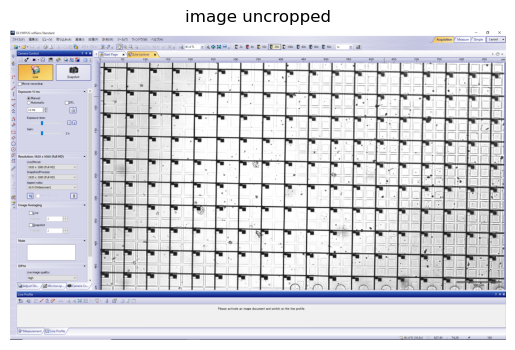

In [15]:
img_crop_test = cv2.imread(media_path + "random/capture.png")
plt.imshow(cv2.cvtColor(img_crop_test, cv2.COLOR_BGR2RGB))
plt.title('image uncropped')
plt.axis('off')  # Turn off axis
plt.show()

#### Isolating top left electrode, User coordinates
This adds a feature that isolates the top left electrode (highlighted in red), from the previous frame, and then asks the User for the "coordinates" for the said electrode so as to label every other electrode
Once the coordinate has been obtained, it maps the rest of the grid

In [55]:
def top_left_electrode(bounding_rectangles, smallest_x, smallest_y):
        if(len(bounding_rectangles)==1):
                print("NO bounding rectangles registered yet")
                return float('inf'), float('inf'), -math.inf, -math.inf
        
        #Convert bounding_boxes to a NumPy array
        bounding_rectangles_array = np.array(bounding_rectangles[1:])
        #Extract x and y coordinates from bounding_rectangles_array
        x_coordinates = bounding_rectangles_array[:, 0]
        y_coordinates = bounding_rectangles_array[:, 1]

        #Find the indices of the smallest x and y values
        min_x_index = np.argmin(x_coordinates)
        min_y_index = np.argmin(y_coordinates)
        max_x_index = np.argmax(x_coordinates)
        max_y_index = np.argmax(y_coordinates)

        #Get the smallest x and y values
        smallest_x = x_coordinates[min_x_index]
        smallest_y = y_coordinates[min_y_index]
        biggest_x = x_coordinates[max_x_index]
        biggest_y = y_coordinates[max_y_index]
        return smallest_x, smallest_y, biggest_x, biggest_y

In [56]:
def annote_positions(tft_size, frame, smallest_x, smallest_y, width, height):
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos_x_increment, pos_y_increment = smallest_x + tft_size/2 -(width+width/3)/width,  smallest_y + tft_size/2 - (height+height/3)/height ##minus (height+height/3)/height for text width or height
    cnt = 0 
    ###write down X axis
    while(pos_x_increment < width):
        cv2.putText(frame, str(cnt),(round(pos_x_increment), round(smallest_y - tft_size/10)), font, (width+width/3)/width, (0, 0, 255), 2, cv2.LINE_AA)
        pos_x_increment = pos_x_increment + tft_size
        cnt = cnt+1
    cnt = 0
    while(pos_y_increment < height):
        cv2.putText(frame, str(cnt), (round(smallest_x - tft_size/10), round(pos_y_increment)), font, (height+height/3)/height, (0, 0, 255), 2, cv2.LINE_AA)
        pos_y_increment = pos_y_increment + tft_size
        cnt = cnt+1


#### Stream crop function
This function serves in the case that direct camera access is restricted. It isolates the video stream from the software on screen, by removing to the left, and to the top, up to tft_size/2.

In [18]:
def stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame):
    return frame[smallest_x:biggest_x, smallest_y:biggest_y]

In [90]:
delay = 2 
frame_nb_tft_size = 50
thresh_px = 15
frame_cnt = 0
tft_size = 0
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]
is_top_left_electrode_annotated = False
pos_annoted = False
pos_written = False

##Coordinates of top left corner electrode
smallest_x, smallest_y, biggest_x, biggest_y = float('inf'), float('inf'), -math.inf, -math.inf

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 160, 205, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            pos_written = False
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            if(abs(x - smallest_x) <= thresh_px and abs(y - smallest_y) <= thresh_px):
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(thresh, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 0, 255), 3)
                                is_top_left_electrode_annotated = True
                            else:
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(thresh, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                        if(pos_annoted and not pos_written):
                            annote_positions(tft_size, frame_trans_contour, smallest_x, smallest_y, width, height)
                            pos_written = True
            #Input on w
            if cv2.waitKey(1) & 0xFF == ord('w'):
                X_input = input("Please write x coordinate of the highlighted red electrode.")
                Y_input = input("Please write y coordinate of the highlighted red electrode.")
                pos_annoted = True
                print(X_input,Y_input)


            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)
            tft_sizes = []
            smallest_x, smallest_y, biggest_x, biggest_y = top_left_electrode(bounding_rectangles, smallest_x, smallest_y)
            bounding_rectangles = [[-100, -111, -222, -333]]


    #Display Frame
        '''if(is_top_left_electrode_annotated):
            cv2.imshow('Frame',stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame_trans_contour))
        else:'''
        cv2.imshow('Frame',thresh)
    

    #Print on p
    if cv2.waitKey(1) & 0xFF == ord('p'):
        print(bounding_rectangles, tft_size)
        
    #Exit on q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### Data Split into a np array

#### Video recording
This part of the algorithm records a video along with the data associated to each electrode, delimited by "bounding_rectangles". 
- While the video is being recorded, data from each bounding rectangle data according to time, and according to it's gate and position is saved into a file, and input data for the top left electrode coordinates is also stored.
- Post processing of the data, to analyze and combine it to other forms of data will allow the association and correction of electrode coordinates, along with the timestamps associated to them, following a specific time rate.
- Cropping of the video or electrophysiological data to fit


#### Exceptions :

- (Maybe )This approach considers cases where FPS is too slow or too rapid, by adjusting the frame rate in accordance to the set frame rate.
- It saves each bounding rectangle data according to time, and according to it's gate and position.

In [20]:
import os
from datetime import datetime
data_path = "C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/"
rect_path = data_path + 'bounding_rect_data/'
vid_path  = data_path + 'video_data/'

#### Clean Rectangle function update, to save each rectangle into a file

In [21]:
def rect_coordinates(top_left_X_input, top_left_Y_input, bounding_rectangles):
    return

In [57]:
def clean_rectangle(new_rect, bounding_rectangles, thresh, filename, frame_nb):
    for rect in bounding_rectangles :
        if (abs(new_rect[0] - rect[0]) <= thresh) and (abs(new_rect[1] - rect[1]) <= thresh):
            #########This below case is the case where it is a same or way bigger square. If it is, then we ignore
            if (new_rect[2] >= rect[2] + thresh ) :
                return rect[0], rect[1], rect[2], rect[3]
        else:
            x, y, w, h = new_rect[0], new_rect[1], new_rect[2], new_rect[3]
            bounding_rectangles.append([x, y, w, h])
            if not os.path.exists(filename):
                open(filename, 'w').close()
            ###add to file
            with open(filename, 'a') as file_to_write:
                file_to_write.write(f'{frame_nb} {x} {y} {w} {h}\n')
            return x,y,w,h

In [ ]:
delay = 2 
frame_nb_tft_size = 50
thresh_px = 15
frame_cnt = 0
frame_previous = -1
tft_size = 0
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]
is_top_left_electrode_annotated = False
pos_annoted = False
pos_written = False

##Coordinates of top left corner electrode
smallest_x, smallest_y, biggest_x, biggest_y = float('inf'), float('inf'), -math.inf, -math.inf

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))

#Define the codec
fourcc = cv2.VideoWriter_fourcc(*'XVID')
###file name
now = datetime.now()
date_str, time_str = now.strftime("%d-%m-%Y"), now.strftime("%H-%M")
output_name = f"{date_str}_{time_str}"
output_video_name = output_name + '.avi'
###videoWriter Object
out = cv2.VideoWriter(vid_path + output_video_name, fourcc, 20.0, (int(width), int(height))) 

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        if(frame_previous>frame_cnt):
            print("unexpected frame reset")
        frame_previous = frame_cnt
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 160, 205, cv2.THRESH_BINARY) ###90 155 thresh best settings for Arthur microscope
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            pos_written = False
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px, rect_path + output_name, frame_cnt)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            if(abs(x - smallest_x) <= thresh_px and abs(y - smallest_y) <= thresh_px):
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 0, 255), 3)
                                is_top_left_electrode_annotated = True
                            else:
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                        if(pos_annoted and not pos_written):
                            annote_positions(tft_size, frame_trans_contour, smallest_x, smallest_y, width, height)
                            pos_written = True
            #Input on w
            if cv2.waitKey(1) & 0xFF == ord('w'):
                X_input_top_left = input("Please write x coordinate of the highlighted red electrode.")
                Y_input_top_left = input("Please write y coordinate of the highlighted red electrode.")
                pos_annoted = True


            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)
            tft_sizes = []
            smallest_x, smallest_y, biggest_x, biggest_y = top_left_electrode(bounding_rectangles, smallest_x, smallest_y)
            bounding_rectangles = [[-100, -111, -222, -333]]


    #Display Frame
        '''if(is_top_left_electrode_annotated):
            cv2.imshow('Frame',stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame_trans_contour))
        else:'''
        out.write(frame_trans_contour)  
        cv2.imshow('Frame',frame_trans_contour)
    

    #Print on p
    if cv2.waitKey(1) & 0xFF == ord('p'):
        print(bounding_rectangles, tft_size)
        
    #Exit on q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(f'FRAME NB : {frame_cnt}')
        with open(rect_path + output_name, 'a') as file_rect:
                file_rect.write(f'{frame_cnt}\n')
        break
    

cap.release()
out.release()
cv2.destroyAllWindows()

NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding rectangles registered yet
NO bounding 

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/bounding_rect_data/19-07-2024_16-26'

### Additional Details
There are some additional details to consider. 
This implementation does not take consideration : 
- potential tilt of the camera stream. A further implementation should take it into consideration.
- Individual camera differences, a calibration with a check board might be necessary.
- check sudden displacement and recalculate top left electrode position.

## Image Analysis

- Needs to be independant from : Zoom 

## Threading
